In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
df = pd.read_csv("/content/df_master_processed.csv")
df=df.drop(columns=["ID","BIRTHYEAR","STATE","CITY","HEALTHCARE_EXPENSES","HEALTHCARE_COVERAGE","MEDICATION_COUNT"])
df = df.dropna()

In [6]:
df.head()

,AGE,MARITAL,RACE,ETHNICITY,GENDER,COUNTY,ADHERENCE
0,32,M,white,hispanic,M,Hampden County,1
1,38,M,white,nonhispanic,M,Middlesex County,1
2,29,M,white,nonhispanic,M,Hampden County,1
3,43,M,white,nonhispanic,F,Middlesex County,1
8,51,M,white,hispanic,F,Bristol County,1


In [ ]:
#df = pd.get_dummies(df, columns=["MARITAL","RACE","ETHNICITY","GENDER","COUNTY"])

In [7]:
race={}
for i,x in enumerate(list(df["RACE"].unique())):
  race[x]=i+1 
print(race)
eth={}
for i,x in enumerate(list(df["ETHNICITY"].unique())):
  eth[x]=i+1  
print(eth)
county={}
for i,x in enumerate(list(df["COUNTY"].unique())):
  county[x]=i+1   
print(county)
df["RACE"] = df["RACE"].apply(lambda x:race[x])
df["ETHNICITY"] = df["ETHNICITY"].apply(lambda x:eth[x])
df["COUNTY"] = df["COUNTY"].apply(lambda x:county[x])
df["GENDER"]=df["GENDER"].apply(lambda x : 0 if x=="M" else 1)
df["MARITAL"]=df["MARITAL"].apply(lambda x : 0 if x=="M" else 1)

{'white': 1, 'native': 2, 'asian': 3, 'black': 4, 'other': 5}
{'hispanic': 1, 'nonhispanic': 2}
{'Hampden County': 1, 'Middlesex County': 2, 'Bristol County': 3, 'Norfolk County': 4, 'Suffolk County': 5, 'Plymouth County': 6, 'Essex County': 7, 'Worcester County': 8, 'Franklin County': 9, 'Hampshire County': 10, 'Barnstable County': 11, 'Berkshire County': 12, 'Dukes County': 13, 'Nantucket County': 14}


In [8]:
df.head()

,AGE,MARITAL,RACE,ETHNICITY,GENDER,COUNTY,ADHERENCE
0,32,0,1,1,0,1,1
1,38,0,1,2,0,2,1
2,29,0,1,2,0,1,1
3,43,0,1,2,1,2,1
8,51,0,1,1,1,3,1


In [ ]:
df.to_csv("prediction_master_new.csv",index=False)

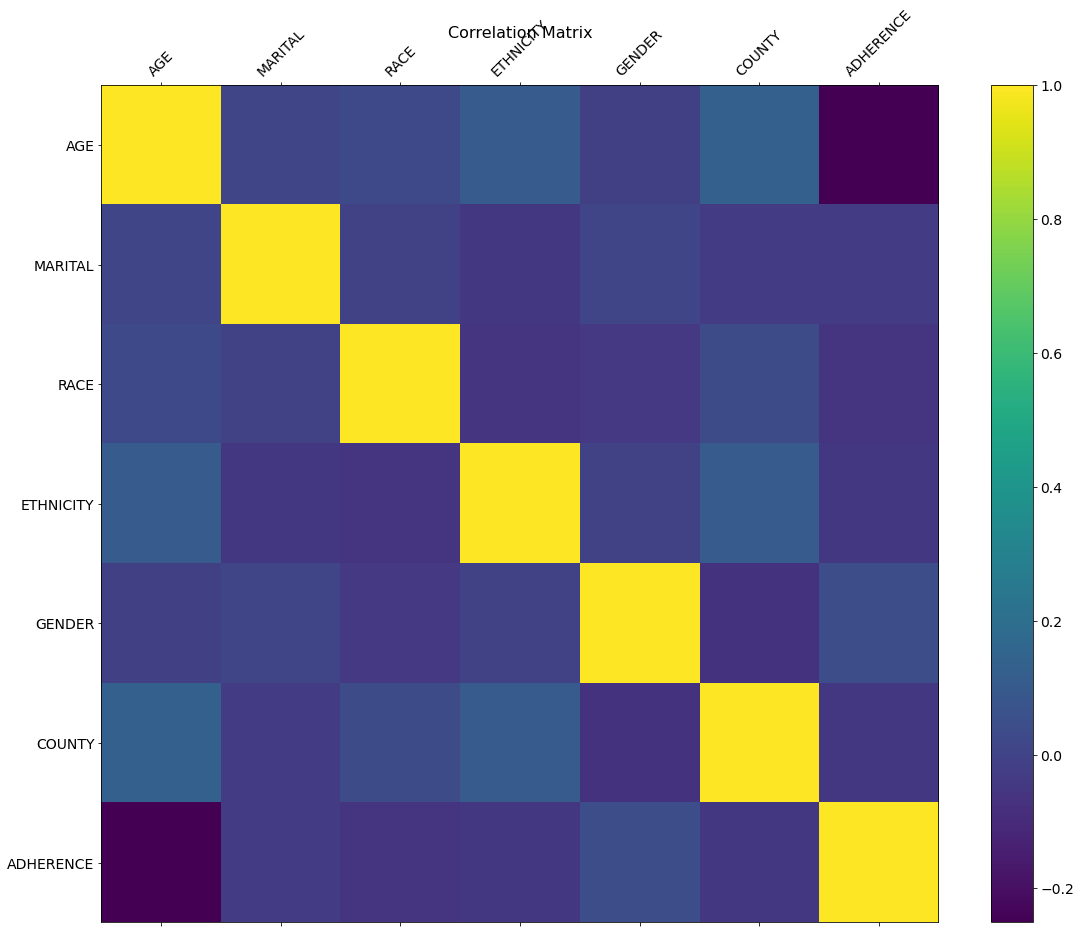

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
y = df["ADHERENCE"]
x = df.drop(columns=["ADHERENCE"])

In [ ]:
columns = list(x.columns)
print(columns)

['AGE', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'COUNTY']


In [ ]:
input_features = 'input_features'
pickle.dump(columns, open(input_features, 'wb'))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(x)
x_scaled = min_max_scaler.transform(x)
x = pd.DataFrame(x_scaled)

In [ ]:
import pickle
scalerfile = 'scaler'
pickle.dump(min_max_scaler, open(scalerfile, 'wb'))

In [ ]:
from torch.utils.data import Dataset,random_split ,DataLoader

In [ ]:
class CSVDataset(Dataset):
  
  # load the dataset
  def __init__(self, x,y):
    # store the inputs and outputs
    self.X = x
    self.y = y
 
  # number of rows in the dataset
  def __len__(self):
    return len(self.X)
 
  # get a row at an index
  def __getitem__(self, idx):
    x_data=torch.tensor(self.X.iloc[idx].values,dtype=torch.float)
    if len(self.y)==0:
       return [x_data] 
    y_data=torch.tensor(int(self.y.iloc[idx]),dtype=torch.float)
    return [x_data,y_data]

In [ ]:
dataset= CSVDataset(x,y)

In [ ]:
# select rows from the dataset
train_set_size = int(len(x) * 0.8)
valid_set_size = len(x) - train_set_size

train, valid = random_split(dataset, [train_set_size, valid_set_size])
# create a data loader for train and test sets

batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=32, shuffle=False)

# Training

In [ ]:
input_features = x.shape[1]
output_features = 1
print(input_features)
print(output_features)

6
1


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(input_features, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(512, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Linear(512, output_features),
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
# validation function
def validate(model, dataloader, criterion,val_data,device):
  print('Validating')
  model.eval()
  counter = 0
  val_running_loss = 0.0
  with torch.no_grad():
    for i, data in enumerate(dataloader):
      counter += 1
      data, target = data[0].to(device), data[1].to(device)
      target = target.unsqueeze(1).float()
      outputs = model(data)
      # apply sigmoid activation to get all the outputs between 0 and 1
      outputs = torch.sigmoid(outputs)
      loss = criterion(outputs, target)
      val_running_loss += loss.item()
        
    val_loss = val_running_loss / counter
    return val_loss

In [ ]:
# training function
def train(model, dataloader, optimizer, criterion, train_data,device):
  
  print('Training')
  model.train()
  counter = 0
  train_running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader):
    counter += 1
    data, target = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(data)
    # apply sigmoid activation to get all the outputs between 0 and 1
    outputs = torch.sigmoid(outputs)
    target = target.unsqueeze(1).float()
    loss = criterion(outputs, target)
    train_running_loss += loss.item()
    # backpropagation
    loss.backward()
    # update optimizer parameters
    optimizer.step()
        
  train_loss = train_running_loss / counter
  return train_loss

In [ ]:
#intialize the model
model = NeuralNetwork().to(device)
# learning parameters
lr = 0.0001
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
def calculate_accuracy():
  model.eval()
  score = 0
  total = 0
  with torch.no_grad():
    for i, data in enumerate(train_loader):
      data, target = data[0].to(device), data[1].to(device)
      target = target.unsqueeze(1).float().detach().cpu().numpy()[0]
      outputs = model(data)
      # apply sigmoid activation to get all the outputs between 0 and 1
      outputs = torch.sigmoid(outputs).detach().cpu().numpy()
      outputs = np.array([0 if x<0.5 else 1 for x in outputs])
      outputs  =target*outputs
      score+=(outputs == target).sum()
      total+=len(outputs)
    
    print("Train accuraccy : {}".format(score/total))
    score = 0
    total = 0
    for i, data in enumerate(valid_loader):
      data, target = data[0].to(device), data[1].to(device)
      target = target.unsqueeze(1).float().detach().cpu().numpy()[0]
      outputs = model(data)
      # apply sigmoid activation to get all the outputs between 0 and 1
      outputs = torch.sigmoid(outputs).detach().cpu().numpy()
      outputs = np.array([0 if x<0.5 else 1 for x in outputs])
      score+=(outputs == target).sum()
      total+=len(outputs)

    print("Valid accuraccy : {}".format(score/total))

In [ ]:
train_loss = []
valid_loss = []
best_loss= np.inf

In [ ]:
# start the training and validation

for epoch in range(epochs):
  print(f"Epoch {epoch+1} of {epochs}")
  train_epoch_loss = train(model, train_loader, optimizer, criterion, train , device)
  valid_epoch_loss = validate(model, valid_loader, criterion, valid, device)
  train_loss.append(train_epoch_loss)
  valid_loss.append(valid_epoch_loss)
  calculate_accuracy()
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {valid_epoch_loss:.4f}')
  # save the trained model to disk
  if (valid_epoch_loss<best_loss):
    torch.save(
      {model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),'loss': criterion},
       'model_best.pth'.format(epoch+1))
    best_loss=valid_epoch_loss

Streaming output truncated to the last 5000 lines.
Train Loss: 0.6794
Val Loss: 0.7013
Epoch 287 of 1000
Training
Validating
Train accuraccy : 0.9525316455696202
Valid accuraccy : 0.7861635220125787
Train Loss: 0.6780
Val Loss: 0.7045
Epoch 288 of 1000
Training
Validating
Train accuraccy : 0.9636075949367089
Valid accuraccy : 0.779874213836478
Train Loss: 0.6782
Val Loss: 0.7072
Epoch 289 of 1000
Training
Validating
Train accuraccy : 0.9604430379746836
Valid accuraccy : 0.7735849056603774
Train Loss: 0.6838
Val Loss: 0.7024
Epoch 290 of 1000
Training
Validating
Train accuraccy : 0.9572784810126582
Valid accuraccy : 0.779874213836478
Train Loss: 0.6879
Val Loss: 0.7008
Epoch 291 of 1000
Training
Validating
Train accuraccy : 0.9857594936708861
Valid accuraccy : 0.7924528301886793
Train Loss: 0.6795
Val Loss: 0.7132
Epoch 292 of 1000
Training
Validating
Train accuraccy : 0.9477848101265823
Valid accuraccy : 0.7672955974842768
Train Loss: 0.6832
Val Loss: 0.6976
Epoch 293 of 1000
Training


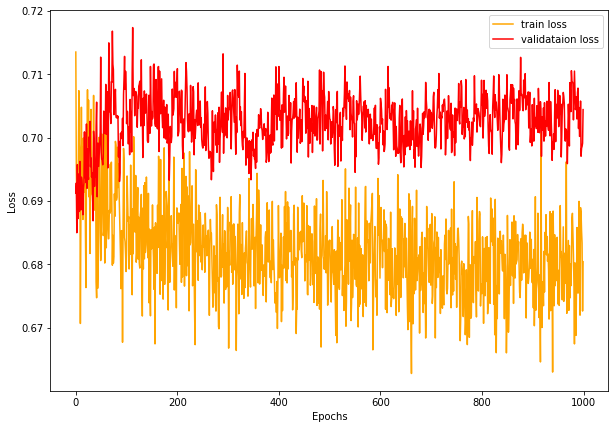

In [ ]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
modelfile = 'saved_model'
pickle.dump(model, open(modelfile, 'wb'))